In [1]:
# Render offscreen -- make sure to set the PyOpenGL platform
from utils import render
import glob
import trimesh
import numpy as np

def add_floor(mesh, mesh_color=[235, 128, 52], floor_color=[255, 255, 255]):
    floor_val = np.min(mesh.vertices, axis=0)[1]
    floor_verts = [[-10, floor_val, -10],
                   [-10, floor_val, +10],
                   [+10, floor_val, -10],
                   [+10, floor_val, +10]]
    floor_verts = np.array(floor_verts).astype(np.float32)
    floor_faces = np.array([[1, 2, 0], [3, 2, 1]]).astype(np.int64)
    vm = mesh.vertices
    fm = mesh.faces
    floor_faces += vm.shape[0]
    v = np.concatenate([vm, floor_verts])
    f = np.concatenate([fm, floor_faces])
    cm = np.array(mesh_color) / 255.
    cf = np.array(floor_color) / 255.
    c = np.concatenate([np.tile(cm, [vm.shape[0], 1]),
                        np.tile(cf, [4, 1])], axis=0)
    print(c)
    print(c.shape)
    print(v.shape)
    mesh_out = trimesh.Trimesh(v, f)
    mesh_out.visual.vertex_colors = c
    return mesh_out

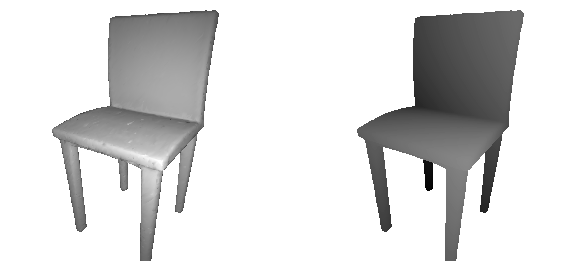

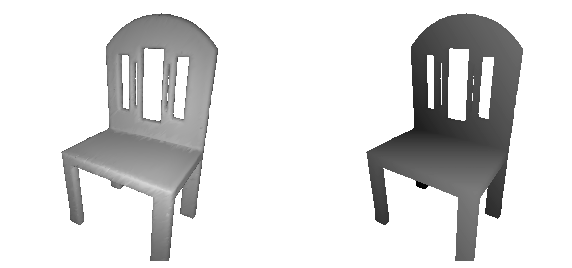

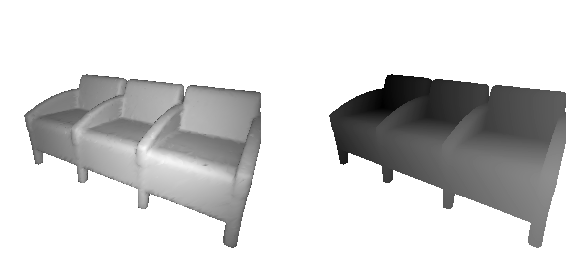

In [2]:
meshnames = sorted(glob.glob('data/shapenet_simplified/val/03001627/*/*.ply'))
eye_1 = [.8, .4, -.5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]

for idx in range(3):
    mesh = trimesh.load(meshnames[idx])
    color, depth, _, _ = render.render_trimesh(mesh, eye_1, center, up, res=(512, 512), light_intensity=6)
    # Show the images
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(color)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(depth, cmap=plt.cm.gray_r)
    plt.show()

## Unproject depth map to point cloud

In [ ]:
# take a sample point cloud from a shape
m = trimesh.load("data/shapenet_watertight/val/03001627/bcc73b8ff332b4df3d25ee35360a1f4d/model_occnet.ply")

eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]
img, depth, world2cam, cam2img = render_trimesh(m, eye_1, center, up, light_intensity=3)
points_unproj = unproject_depth_img(depth, cam2img, world2cam)
points_unproj_img_sameview, _, _, _ = render_trimesh(trimesh.PointCloud(points_unproj), 
                                                     eye_1, center, up, light_intensity=3)
points_unproj_img_diffview, _, _, _ = render_trimesh(trimesh.PointCloud(points_unproj), 
                                                     eye_2, center, up, light_intensity=3)
colors = np.zeros_like(points_unproj); colors[:, 1] = 1
points_unproj_img_overlay, _, _, _ = render_trimesh([trimesh.PointCloud(points_unproj, colors=colors),
                                                     m], eye_2, center, up, light_intensity=3)

fig, axes = plt.subplots(figsize=(25, 5), ncols=5)
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Rendered mesh (RGB)")

d = depth.copy()
d[depth==0] = np.nan
axes[1].set_title("Rendered mesh (Depth)")
c = axes[1].imshow(d)
axes[1].axis('off')

axes[2].imshow(points_unproj_img_sameview)
axes[2].axis('off')
axes[2].set_title("Unprojected points (same viewpoint)")

axes[3].imshow(points_unproj_img_diffview)
axes[3].axis('off')
axes[3].set_title("Unprojected points (diff viewpoint)")

axes[4].imshow(points_unproj_img_overlay)
axes[4].axis('off')
axes[4].set_title("Unprojected points (overlay)")

# fig.colorbar(c, ax=axes[1])
plt.show()

In [ ]:
import pyrender
from utils import render
import glob
import trimesh
import numpy as np

eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]

def line_meshes(verts, edges, colors=None, poses=None):
    """Create pyrender Mesh instance for lines.
    
    Args:
      verts: np.array floats of shape [#v, 3]
      edges: np.array ints of shape [#e, 3]
      colors: np.array floats of shape [#v, 3]
      poses: poses : (x,4,4)
             Array of 4x4 transformation matrices for instancing this object.
    """
    prim = pyrender.primitive.Primitive(
        positions=verts,
        indices=edges,
        color_0=colors,
        mode=pyrender.constants.GLTF.LINES,
        poses=poses)
    return pyrender.mesh.Mesh(primitives=[prim], is_visible=True)

# render lines
verts = np.array([[-.5, 0, 0],
                  [+.5, 0, 0]])
edges = np.array([0, 1])
line_mesh = line_meshes(verts, edges)
img, _, _, _ = render.render_trimesh([line_mesh], eye_1, center, up, light_intensity=3)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()